In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from plotnine import *

# Data Cleaning

In [2]:
#Cleaning Data
hitters = pd.read_csv("/Users/AustinLiu/Desktop/GSB544-ComputingandMachineLearning/Lab_Data/Hitters.csv")
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
hitters.dtypes

AtBat          int64
Hits           int64
HmRun          int64
Runs           int64
RBI            int64
Walks          int64
Years          int64
CAtBat         int64
CHits          int64
CHmRun         int64
CRuns          int64
CRBI           int64
CWalks         int64
League        object
Division      object
PutOuts        int64
Assists        int64
Errors         int64
Salary       float64
NewLeague     object
dtype: object

In [4]:
df = hitters.dropna()
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


# Part 1: Different Model Specs

## A. Regression without regularization

In [5]:
X = df.drop("Salary", axis=1)
y = df["Salary"]


ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, 
                                  handle_unknown='ignore', 
                                  drop='first'), 
         make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), 
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

In [6]:
lr_pipeline.fit(X, y)

lr_coef = lr_pipeline.named_steps["linear_regression"].coef_

#GPT Assisted
lr_names = (lr_pipeline.named_steps['preprocessing']
.transformers_[0][1]
.get_feature_names_out(input_features=X
.select_dtypes(include=[object])
.columns.tolist())
 .tolist() 
 + X.select_dtypes(include=[np.number]).columns.tolist())

In [7]:
pd.DataFrame(lr_coef, lr_names)


,0
League_N,62.599423
Division_W,-116.849246
NewLeague_N,-24.762325
AtBat,-291.094556
Hits,337.830479
HmRun,37.853837
Runs,-60.572479
RBI,-26.994984
Walks,135.073897
Years,-16.693359


Interpretation of Important Coefficients: <br>
- CRuns (480.747): For every one run increase in a player's career their predicted salary would increase by 480.747 thousand dollars. <br>
- CAtBat (-391.039): For every one at bat increase in a player's career their predicted salary would decrease by 391.039 thousand dollars. <br>
- Hits (337.830): For every hit increase in 1986, a player's predicted salary would increase by 337.830 thousand dollars. <br>
- AtBat (-291.094): For every at bat increase in 1986, a player's predicted salary would decrease by 291.094 thousand dollars. <br>
- CRBI (260.690): For every one RBI increase in a player's career their predicted salary would increase by 260.690 thousand dollars. <br>

In [8]:
-cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

121136.31031816879

The expected MSE for predicting salaries in 1989 in 121,136.31.

## B. Ridge Regression

In [9]:
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]
    ).set_output(transform="pandas")

ridge_pipeline.fit(X, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X, y)

positive_mse_scores = -gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores})

,Alphas,Scores
0,0.001,121124.318914
1,0.010,121021.508944
2,0.100,120329.936014
3,1.000,119034.332720
4,10.000,119073.956166


The best Lambda parameter was 1 with lowest MSE equal to 119,034.333.

In [10]:
ridge_pipeline.fit(X, y)

ridge_coef = ridge_pipeline.named_steps['ridge_regression'].coef_
ridge_names = (ridge_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

In [11]:
pd.DataFrame(ridge_coef, ridge_names)

,0
League_N,58.555947
Division_W,-119.076927
NewLeague_N,-24.027205
AtBat,-271.088165
Hits,296.801967
HmRun,17.973971
Runs,-29.212352
RBI,-8.909304
Walks,124.344012
Years,-38.619131


Interpretation of Important Coefficients: <br>
- CRuns (320.803): For every one run increase in a player's career their predicted salary would increase by 320.803 thousand dollars. <br>
- Hits (296.802): For every hit increase in 1986, a player's predicted salary would increase by 296.802 thousand dollars. <br>
- AtBat (-271.088): For every at bat increase in 1986, a player's predicted salary would decrease by 271.088 thousand dollars. <br>
- CAtBat (-225.512): For every one at bat increase in a player's career their predicted salary would decrease by 225.512 thousand dollars. <br>
- CWalks (-184.289): For every one walk increase in a player's career their predicted salary would decrease by 184.289 thousand dollars. <br>

In [12]:
-cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

119034.33271954537

The expected MSE for predicting salaries in 1989 in 119,034.33.

## C. Lasso Regression

In [13]:
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

lasso_pipeline.fit(X, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X, y)

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores2})

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/pyt

,Alphas,Scores
0,0.001,120994.179815
1,0.010,120964.764686
2,0.100,120682.252637
3,1.000,119761.587407
4,10.000,121828.141333


The best Lambda parameter was 1 with lowest MSE equal to 119,761.587.

In [14]:
lasso_pipeline.fit(X, y)

lasso_coef = lasso_pipeline.named_steps['lasso_regression'].coef_
lasso_names = (lasso_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

In [15]:
pd.DataFrame(lasso_coef, lasso_names)

,0
League_N,35.826072
Division_W,-114.412951
NewLeague_N,-0.000000
AtBat,-282.370957
Hits,304.359509
HmRun,11.127022
Runs,-24.966507
RBI,-0.000000
Walks,120.695275
Years,-34.948148


Interpretation of Important Coefficients: <br>
- CRuns (375.566): For every one run increase in a player's career their predicted salary would increase by 375.566 thousand dollars. <br>
- Hits (304.360): For every hit increase in 1986, a player's predicted salary would increase by 304.360 thousand dollars. <br>
- AtBat (-282.371): For every at bat increase in 1986, a player's predicted salary would decrease by 282.371 thousand dollars. <br>
- CRBI (-192.611): For every one at bat increase in a player's career their predicted salary would decrease by 192.611 thousand dollars. <br>
- CWalks (-189.645): For every one walk increase in a player's career their predicted salary would decrease by 189.645 thousand dollars. <br>

In [16]:
-cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03


119761.58740741301

The expected MSE for predicting salaries in 1989 in 119,761.59.

## D. Elastic Net

In [17]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv3_fitted = gscv3.fit(X, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)

df_elasticnet = results[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
df_elasticnet["mean_test_score"] = df_elasticnet["mean_test_score"].abs()

df_elasticnet.sort_values(by = "mean_test_score", ascending = True).head()


/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.044e+07, tolerance: 4.708e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.219e+06, tolerance: 3.606e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.036e+07, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/pyt

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.983e+06, tolerance: 3.606e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.015e+07, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.817e+06, tolerance: 4.281e+03
/Users/AustinLiu/anaconda3/lib/pyt

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.541e+03, tolerance: 4.708e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e+04, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.656e+03, tolerance: 4.281e+03
/Users/AustinLiu/anaconda3/lib/pyt

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
9,0.01,0.01,118777.528114
10,0.01,0.05,118787.823481
24,0.1,0.9,118794.049617
11,0.01,0.1,118802.210703
23,0.1,0.7,118841.088130


The best model is where alpha = 0.01 and l1 ratio = to 0.01. It's MSE is 118,777.53.

In [18]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=0.01, l1_ratio = 0.01))]
    ).set_output(transform="pandas")

In [19]:
elastic_net_pipeline.fit(X, y)

elastic_coef = elastic_net_pipeline.named_steps['elastic_net'].coef_

elastic_names = (elastic_net_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

In [20]:
pd.DataFrame(elastic_coef, elastic_names)

,0
League_N,53.200620
Division_W,-119.180961
NewLeague_N,-20.187706
AtBat,-234.665655
Hits,250.804453
HmRun,5.192495
Runs,-6.858256
RBI,2.268095
Walks,111.892944
Years,-49.330996


Interpretation of Important Coefficients: <br>
- Hits (250.804): For every hit increase in 1986, a player's predicted salary would increase by 250.804 thousand dollars. <br>
- AtBat (-234.666): For every at bat increase in 1986, a player's predicted salary would decrease by 234.666 thousand dollars. <br>
- CRuns (228.373): For every one run increase in a player's career their predicted salary would increase by 228.373 thousand dollars. <br>
- CWalks (-156.509): For every one walk increase in a player's career their predicted salary would decrease by 156.509 thousand dollars. <br>
- CAtBat (-123.130): For every one at bat increase in a player's career their predicted salary would decrease by 123.130 thousand dollars. <br>


In [21]:
-cross_val_score(elastic_net_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

118777.52811409494

The expected MSE for predicting salaries in 1989 in 118,777.53.

# Part 2

### Based on preferred model Elastic Net with lowest MSE value,

The most important numeric variable is Hits. <br>

The five most important numeric variables are <br>

1. Hits<br>
2. AtBat <br>
3. CRuns <br>
4. CWalks <br>
5. CAtBat <br>

The most important categorical variable is Division.

### Feature Set 1: Best Numeric

#### Linear Regression

In [22]:
X1 = df[["Hits"]]

In [23]:
lr_pipeline.fit(X1, y)

-cross_val_score(lr_pipeline, X1, y, cv=5, scoring='neg_mean_squared_error').mean()

173088.97286444035

In [24]:
lr_pipeline.named_steps["linear_regression"].coef_

array([197.51778566])

#### Ridge Regression

In [25]:
ridge_pipeline.fit(X1, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X1, y)

positive_mse_scores = -gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores})

,Alphas,Scores
0,0.001,173088.928981
1,0.010,173088.534138
2,0.100,173084.595954
3,1.000,173046.230311
4,10.000,172755.975523


In [26]:
ridge_pipeline.named_steps['ridge_regression'].coef_

array([196.76961223])

#### Lasso Regression

In [27]:
lasso_pipeline.fit(X1, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X1, y)

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores2})

,Alphas,Scores
0,0.001,173088.959793
1,0.010,173088.842244
2,0.100,173087.675961
3,1.000,173076.934306
4,10.000,173061.634500


#### Elastic Net

In [28]:
elastic_net_pipeline.fit(X1, y)

alphas = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv3_fitted = gscv3.fit(X1, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)

df_elasticnet = results[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
df_elasticnet["mean_test_score"] = df_elasticnet["mean_test_score"].abs()

df_elasticnet.sort_values(by = "mean_test_score", ascending = True).head()

/var/folders/zj/cmn5m8zx2ks4q5dddlsx23800000gn/T/ipykernel_11186/2567059551.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
18,0.1,0.01,172587.553352
19,0.1,0.05,172594.055305
20,0.1,0.1,172603.554302
33,1,0.9,172606.813461
21,0.1,0.3,172657.603008


### Feature Set 2: 5 Best Numeric

#### Linear Regression

In [29]:
X2 = df[["Hits", "AtBat", "CRuns", "CWalks", "CAtBat"]]

In [30]:
lr_pipeline.fit(X2, y)

-cross_val_score(lr_pipeline, X2, y, cv=5, scoring='neg_mean_squared_error').mean()

127649.37020397608

In [31]:
lr_pipeline.named_steps["linear_regression"].coef_

array([ 327.13530336, -196.70615925,  456.3196552 ,   -4.06806169,
       -234.72104822])

#### Ridge Regression

In [32]:
ridge_pipeline.fit(X2, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X2, y)

positive_mse_scores = -gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores})

,Alphas,Scores
0,0.001,127647.792745
1,0.010,127633.693706
2,0.100,127501.963377
3,1.000,126800.370504
4,10.000,128037.290506


In [33]:
ridge_pipeline.named_steps['ridge_regression'].coef_

array([ 307.14994708, -173.5620581 ,  380.50598283,    7.99249969,
       -171.16418186])

#### Lasso Regression

In [34]:
lasso_pipeline.fit(X2, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X2, y)

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores2})

,Alphas,Scores
0,0.001,127648.669635
1,0.010,127642.385917
2,0.100,127581.664974
3,1.000,127186.765080
4,10.000,128429.492437


#### Elastic Net

In [35]:
elastic_net_pipeline.fit(X2, y)

alphas = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv3_fitted = gscv3.fit(X2, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)

df_elasticnet = results[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
df_elasticnet["mean_test_score"] = df_elasticnet["mean_test_score"].abs()

df_elasticnet.sort_values(by = "mean_test_score", ascending = True).head()

/var/folders/zj/cmn5m8zx2ks4q5dddlsx23800000gn/T/ipykernel_11186/3786009875.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
10,0.01,0.05,126646.484716
11,0.01,0.1,126647.176373
9,0.01,0.01,126647.654257
24,0.1,0.9,126660.432983
12,0.01,0.3,126679.489799


### Feature Set 3: 5 Best Numeric + Interaction w/Best Categorical

In [36]:
dummy_variables = pd.get_dummies(df['Division'], prefix='Division')
df = pd.concat([df, dummy_variables["Division_W"]], axis=1)
df

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Division_W
1,315,81,7,24,38,39,14,3449,835,69,...,414,375,N,W,632,43,10,475.0,N,1
2,479,130,18,66,72,76,3,1624,457,63,...,266,263,A,W,880,82,14,480.0,A,1
3,496,141,20,65,78,37,11,5628,1575,225,...,838,354,N,E,200,11,3,500.0,N,0
4,321,87,10,39,42,30,2,396,101,12,...,46,33,N,E,805,40,4,91.5,N,0
5,594,169,4,74,51,35,11,4408,1133,19,...,336,194,A,W,282,421,25,750.0,A,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,311,138,N,E,325,9,3,700.0,N,0
318,492,136,5,76,50,94,12,5511,1511,39,...,451,875,A,E,313,381,20,875.0,A,0
319,475,126,3,61,43,52,6,1700,433,7,...,93,146,A,W,37,113,7,385.0,A,1
320,573,144,9,85,60,78,8,3198,857,97,...,420,332,A,E,1314,131,12,960.0,A,0


In [37]:
df["Hits * Division"] = df["Hits"] * df["Division_W"]
df["AtBat * Division"] = df["AtBat"] * df["Division_W"]
df["CRuns * Division"] = df["CRuns"] * df["Division_W"]
df["CWalks * Division"] = df["CWalks"] * df["Division_W"]
df["CAtBat * Division"] = df["CAtBat"] * df["Division_W"]

#### Linear Regression

In [38]:
X3 = df[["Hits", "AtBat", "CRuns", "CWalks", "CAtBat",
        "Hits * Division", "AtBat * Division",
        "CRuns * Division", "CWalks * Division",
        "CAtBat * Division"]]

In [39]:
lr_pipeline.fit(X3, y)

-cross_val_score(lr_pipeline, X3, y, cv=5, scoring='neg_mean_squared_error').mean()

130636.68738078771

In [40]:
lr_pipeline.named_steps["linear_regression"].coef_

array([ 426.49483187, -286.67785158,  540.99623183,   17.20832853,
       -292.87870069, -429.4538151 ,  409.54818353, -287.52440844,
        -88.52371819,  301.01704405])

#### Ridge Regression

In [41]:
ridge_pipeline.fit(X3, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv = GridSearchCV(ridge_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv_fitted = gscv.fit(X3, y)

positive_mse_scores = -gscv_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores})

,Alphas,Scores
0,0.001,130630.755232
1,0.010,130578.389125
2,0.100,130140.095802
3,1.000,128580.707722
4,10.000,126521.597712


In [42]:
ridge_pipeline.named_steps['ridge_regression'].coef_

array([ 337.34974887, -200.18324589,  381.38337636,   32.37615813,
       -147.54411681, -227.96726531,  207.70868683, -115.87483581,
        -90.77586235,  128.03893682])

#### Lasso Regression

In [43]:
lasso_pipeline.fit(X3, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X3, y)

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"Alphas": [0.001, 0.01, 0.1, 1, 10], "Scores": positive_mse_scores2})

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e+06, tolerance: 4.708e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.007e+05, tolerance: 3.606e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e+06, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/pyt

,Alphas,Scores
0,0.001,130625.791912
1,0.010,130595.890702
2,0.100,130312.918417
3,1.000,129485.233503
4,10.000,125804.434616


#### Elastic Net

In [44]:
elastic_net_pipeline.fit(X3, y)

alphas = {'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
          'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]}

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv3_fitted = gscv3.fit(X3, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)

df_elasticnet = results[["param_elastic_net__alpha", "param_elastic_net__l1_ratio", "mean_test_score"]]
df_elasticnet["mean_test_score"] = df_elasticnet["mean_test_score"].abs()

df_elasticnet.sort_values(by = "mean_test_score", ascending = True).head()

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.827e+06, tolerance: 4.708e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.291e+06, tolerance: 3.606e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.013e+07, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/pyt

/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.315e+04, tolerance: 4.281e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.282e+03, tolerance: 4.558e+03
/Users/AustinLiu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.909e+03, tolerance: 4.137e+03
/Users/AustinLiu/anaconda3/lib/pyt

,param_elastic_net__alpha,param_elastic_net__l1_ratio,mean_test_score
33,1,0.9,125975.849287
44,10,0.99,126108.590962
32,1,0.7,126126.598768
18,0.1,0.01,126145.335186
19,0.1,0.05,126161.285705


# Part 3

A. Ridge <br>
- Feature Set 1: The coefficients were similar, with ridge being slightly smaller. The MSE for Ridge was about 300 smaller than ordinary regression. <br>
- Feature Set 2 & 3: The ridge penalty adjusted the coefficients to be closer to 0 and even flipped signs for one beta. The MSE for Ridge was also smaller than ordinary regression. <br>


This all makes sense because ordinary regression has large coefficients, meaning it is flexible and overfitting. The ridge implements a penalty that reduces the size of betas and SSE. 

B. Lasso <br>
- In Part 1, the Lasso model's best lambda was 1. <br>
- In Part 2, Feature Set 1 and 3, the Lasso model's best lamda was 10. <br>
- Feature Set 2 had a best lambda = 1 <br>

Each case had its own specific Lambda parameter to prevent overfitting. Each feature set had its own unique amount of variables that needed a specific parameter that performed the best.<br>

MSE Part 1: 119761 <br>
MSE Feature 1: 173061 <br>
MSE Feature 2: 127186 <br>
MSE Feature 3: 125804

C. Elastic Net <br>

MSE Part 1: 118777 <br>
MSE Feature 1: 172587 <br>
MSE Feature 2: 126646 <br>
MSE Feature 3: 125975 <br>

Elastic Net always wins because it implements both the ridge and lasso penalties to the model. This creates the model with the lowest MSE

# Part 4

According to the MSE, the best model is the Elastic Net model with all variables and no interactions.

In [65]:
finaldf = hitters.dropna()
finaldf.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [66]:
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1, l1_ratio = 0.9))]
    ).set_output(transform="pandas")

In [67]:
X = finaldf.drop("Salary", axis=1)
y = finaldf["Salary"]

elastic_net_pipeline.fit(X, y)

elastic_coef = elastic_net_pipeline.named_steps['elastic_net'].coef_

elastic_names = (elastic_net_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())


In [68]:
-cross_val_score(elastic_net_pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()

119784.09674844096

In [69]:
y_pred = elastic_net_pipeline.predict(X)

In [70]:
plotdf = pd.DataFrame({"Predictions": y_pred, "Actual": finaldf["Salary"]})
plotdf.head()

,Predictions,Actual
1,484.814417,475.0
2,681.892790,480.0
3,997.773123,500.0
4,486.407237,91.5
5,568.744208,750.0


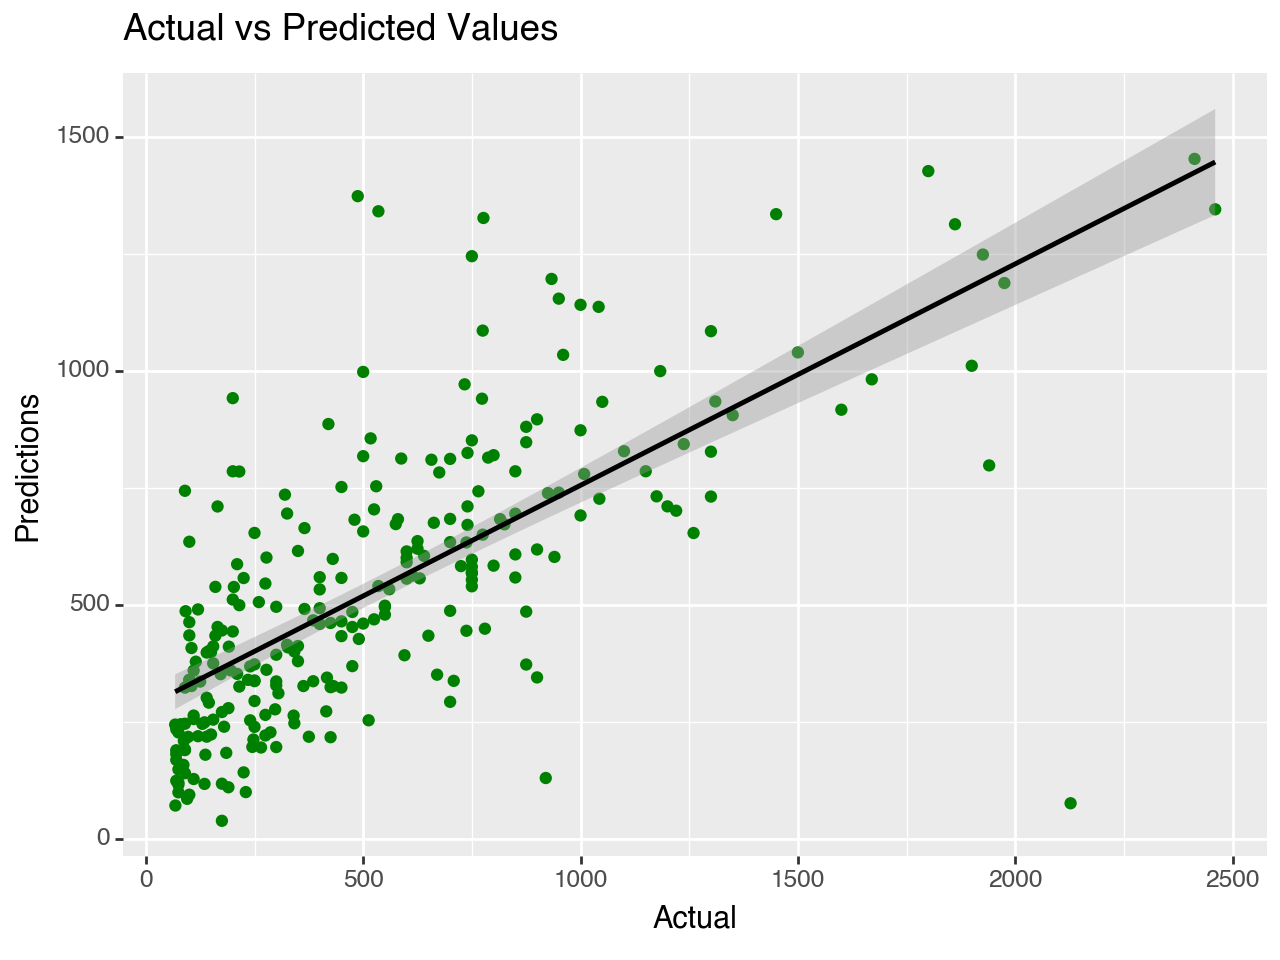

<Figure Size: (640 x 480)>

In [71]:
(ggplot(plotdf, aes(x = "Actual", y = "Predictions")) 
 + geom_point(color = "green")
 + geom_smooth(method = "lm")
 + labs(title = "Actual vs Predicted Values"))

Overall, the actual and predicted follow the line of best fit, meaning that the model has solid performance. It also had the lowest MSE out of all of the tested models.